# Neri Barocci - 53939A
## Ranking Board Games
### Python Project - DSE 25/11

This project aims at ranking board games in the BGG (Board Game Geeks) database based on their user reviews. The project develops alternative solutions to rank the games andd filters the games based on the amount of reviews they have received. The output is a sorted databases and a graph of the top board games given the desired ranking score and desired amount of reviews per game.

### Data

First step, processing the data (importing and cleaning):

In [97]:
import os
import pandas as pd

''' From 'data_processing' module '''

# Setting up path
cwd = os.getcwd()
data_path = os.path.join(cwd, 'data')

# The Rank dataset contains the name (and unique ID) of every game on BGG
# It also includes information on that game including how many users reviewed it and the arithmetic mean score of each game
rank_file = "2022-01-08.csv" 
dataset_ranks = pd.read_csv(f'{data_path}\\{rank_file}')

clean_rank_data  = dataset_ranks.drop(["URL", "Thumbnail", "Unnamed: 0", "Bayes average", 'Year'], axis = 1) 
clean_rank_data = clean_rank_data.rename(columns = {"Users rated" : "Number of Ratings", 'Rank' : 'BGG Rank'})


# Reviews dataset, this dataset contains every individual score plus eventual comment of every game in the rank dataset. 
# It is a huge dataset with 19 Million entries, which forced the project to behave in a certain way.

file_reviews = "bgg-19m-reviews.csv" 
dataset_reviews = pd.read_csv(f'{data_path}\\{file_reviews}') # importing the reviews dataset
clean_review_data = dataset_reviews.drop(["Unnamed: 0", "comment"], axis = 1) # cleaning the dataset, dropping unnecessary columns and renaming others
clean_review_data = clean_review_data.rename(columns = {"user":"User", "rating":"Rating", "name" : "Name_of_Game"})

In [10]:
# Showing the old rank dataset
dataset_ranks.head(1)

,Unnamed: 0,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail
0,105,30549,Pandemic,2008,106,7.59,7.487,108975,/boardgame/30549/pandemic,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...


In [11]:
dataset_reviews.head(1)

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic


In [98]:
# Showing the cleaned rank dataset
clean_rank_data.head(3)

,ID,Name,BGG Rank,Average,Number of Ratings
0,30549,Pandemic,106,7.59,108975
1,822,Carcassonne,190,7.42,108738
2,13,Catan,429,7.14,108024


In [12]:
clean_review_data.head(3)


,User,Rating,ID,Name_of_Game
0,Torsten,10.0,30549,Pandemic
1,mitnachtKAUBO-I,10.0,30549,Pandemic
2,avlawn,10.0,30549,Pandemic


The data is imported and cleaned in a separate module:

In [ ]:
from modules.data_processing import clean_rank_data, clean_review_data

c:\Users\Neri\Downloads\DSE\DATA_MANAGEMENT\PYTHON\python_project(rankingboardgames)\Source\data


### Data Manipulation

Now it's time to manipulate the data.
This section is split in two parts:
the first shows the ranking _algorithm module, which includes the functions that handle the scores of the games.
The second section shows  the dataset by review bracket module, which includes the class of datasets filtered by the desired number of reviews.

#### The Algorithms

Our goal is to find new ways in which to rank the games. The first way presented is the Wilson Function, already included in the project prompt, but I had made it before realizing it, so it is included in the project. The second way is a more specific lower bound of the Bayesian Average.

##### The Wilson Function

We are actually calculating the lower bound of the Wilson Function, which consists of taking the share of positive reviews for a single game and dividing it by the amount of total reviews. Therefore the first step is to find the total reviews a game's received, which is already a column in our rank dataset.

In [ ]:
def total_reviews(dataset_ranks, id):
    '''Find the total number of reviews of a single game given its unique ID'''
    total_reviews = dataset_ranks['Number of Ratings'] # locates column in dataframe where the total number of reviews are
    total_reviews_ID = total_reviews.loc[(dataset_ranks['ID']== id)] # filters the dataframe based on the input id, returns a filtered dataframe
    return int(total_reviews_ID.iloc[0]) # returns the item in the first position of the dataframe input

total_reviews(clean_rank_data, 171) # the ID for Chess

30810

In [ ]:
# We can see Chess indeed has 30810 total ratings
clean_rank_data.loc[(clean_rank_data['Name']== 'Chess')]

,ID,Name,Rank,Average,Number of Ratings
67,171,Chess,430,7.15,30810


Once we have the total number of reviews we have to find the number of positive reviews, which implies determining what a positive review is, and then counting each instance from the reviews dataset for each desired game.

In [ ]:
def count_positive_reviews_per_game(dataset_reviews, id):
        '''returns the positive reviews for a game, a positive review is a review with a rating of at least a 6/10'''
        df_positive_reviews = dataset_reviews.loc[(dataset_reviews["ID"] == id) & (dataset_reviews['Rating'] >= 6.0)] 
        # Again the function filters for a specific review and determines that a positive rating is a rating that is at least 6/10.
        
        positive_reviews_count = df_positive_reviews['Rating'].count() 
        # the variable counts every element in the filtered dataframe
        
        return int(positive_reviews_count)
count_positive_reviews_per_game(clean_review_data, 171) # Chess has 25,543 positive reviews (rated 6 and above)

25543

Then we calculate the share of positive reviews for chess:

In [ ]:
def share_of_positive_reviews_per_game(dataset_ranks, dataset_reviews, id):
        '''Ratio of positive review per total reviews for a single game'''
        share_of_pos_reviews_per_game = float(count_positive_reviews_per_game(dataset_reviews, id) / total_reviews(dataset_ranks, id))
        return round(share_of_pos_reviews_per_game, 4) # rounding the answer to 4 decimals
share_of_positive_reviews_per_game(clean_rank_data, clean_review_data, 171)

0.829

We are finally ready to calculate our Wilson Lower Bound taking the formula from the Evan Miller website. The formula consists in taking a confidence interval in which the 'true' accurate rating is based on the share of positive reviews. 
In order to compute it we first need to find the quantile of a normal distribution 

In [ ]:
import numpy as np
from scipy.stats import norm
# Function to calculate any confidence level
def confidence_level(confidence):
    '''Returns left z score for a confidence level.'''
    cl = norm.ppf(1- (1 - confidence)/2) 
    return cl

# Wilson Function, default at a 95% confidence level
def wilson_function(id, dataset_ranks, dataset_reviews, confidence = .95):
    '''Claculates the lower bound for the share of positive reviews in a game'''
    z = confidence_level(confidence)
    n = total_reviews(dataset_ranks, id)
    p_hat = 1 * share_of_positive_reviews_per_game(dataset_ranks, dataset_reviews, id) 
        
    wilson_score = round(float((p_hat + z**2/(2*n) - z*np.sqrt((p_hat*(1 - p_hat) + z**2/(4*n))/n)) / (1 + (z**2)/n)), 2)
        
    return wilson_score
    
wilson_function(171, clean_rank_data, clean_review_data)

0.82

##### The New Bayesian Average

We move on the second algorithm, since the Wilson Score is imprecise, besides it being in the prompt. That is, the 'New' Bayesian Average. New because it's not the classic Bayesian Average where you weigh the mean of a specific game against the mean of all games dividing by the total number of ratings.
The method implemented in this project first finds how many of each rating a game got (how many 1/10s, 2/10s...). Each rating is then weighted by its score and how many times it was given. Finally it subtracts the uncertainty adjustment, the variability of the ratings, which penalizes the score if the game wasn't highly scored or if the game has polarized reviews. 

In [ ]:
# First we have to find how many ratings of each kind each game has:

def array_scores(id, dataset_reviews):
    '''Returns the number of times a gave received a certain score (how many 1/10s, how many 2/10s...)'''
    list_of_scores = []
    for i in range(1,11):
        how_many_i_reviews = dataset_reviews.loc[(dataset_reviews['ID'] == id) & (dataset_reviews['Rating'].between(i, i + 1, inclusive='left'))]
        this_many_i_reviews = how_many_i_reviews['Rating'].count()
            
        list_of_scores.append(int(this_many_i_reviews))
            
    return list_of_scores

array_scores(171, clean_review_data)

[105, 239, 577, 1367, 3016, 6229, 7197, 4867, 2879, 4371]

In [26]:
# Bayesian lower bound function
def bayesian_average(id, dataset_ranks, dataset_reviews, confidence = .95):
    '''Returns the lower bound of a Bayesian average for the times a game was reviewed and the amount of times a particular score was given'''
    z = confidence_level(confidence)
    n = array_scores(id, dataset_reviews)
    N = sum(n)
    first_part = 0
    second_part = 0
    for k, n_k in enumerate(n):
        first_part += (k+1)*(n_k+1)/(N + 10)
        second_part += (k+1)*(k+1)*(n_k+1)/(N+10)
    score = first_part - z*np.sqrt((second_part - first_part * first_part)/(N+11))
        
    return round(float(score), 2)    
bayesian_average(171, clean_rank_data, clean_review_data)

7.08

Each of these functions is contained in the ranking_algorithms module and is called as:

In [ ]:
import modules.ranking_algorithms as ra

#### The Filtered Datasets

The next logical step in the process would be to run the Wilson Lower Bound function or the New Bayesian Average over the two datasets and sort based on the returning values.
Unfortunately, the dataframes are quite large: the ranks dataset has 21k+ games, while the reviews dataset has almost 19 million individual user review. Computationally the calculations would take hours if we had to run through both databases.
Therefore, the project introduces a further ranking parameter which consists of filtering the datasets by specific number of reviews. This is dictated by the computational constraint of my computer, but that this also aides the general cause. Indeed, it's difficult to compare, by score, a game that was reviewed over 100k times and a game that was reviewed 'only' a 1000 times or even just 30 or 40 times.
Thus, in this way we have a more in depth look at how games that have similar degrees of popularity stack up next to each other in different ways.

##### The filtered dataset class

In [ ]:
class dataset_by_review_bracket():

    def __init__(self, name, rank_database, reviews_database, algorithm, operator, num_of_reviews1):
        self.name = name
        self.rank_database = rank_database
        self.reviews_database = reviews_database
        self.algorithm = algorithm # what kind of score do you want to sort by?
        self.operator = operator
        self.num_of_reviews1 = num_of_reviews1 
        
# the operator and num_of_reviews answer the question how many games should your dataframe have? How many reviews should your games have?
    
    def add_column_to_df_filtered_by_reviews(self, title_of_column = 'New Column', num_upperbound_reviews = None):
        
        ''' The method filters two dfs: the rank df by the desired number of reviews, and then the review df based on the items in the new rank df'''
        # filtering the rank database based on a preferred number/range of reviews
    
        if self.operator == 'equal':
            filtered_rank_data = self.rank_database[self.rank_database['Number of Ratings'] == self.num_of_reviews1]
        elif self.operator == 'greater':
            filtered_rank_data = self.rank_database[self.rank_database['Number of Ratings'] > self.num_of_reviews1]
        elif self.operator == 'between':
            filtered_rank_data = self.rank_database[self.rank_database['Number of Ratings'].between(self.num_of_reviews1, num_upperbound_reviews)]
        else:
            filtered_rank_data = self.rank_database[self.rank_database['Number of Ratings'] < self.num_of_reviews1]
         
        # filtering the review data based on the filtered rank database
        desired_ids = filtered_rank_data['ID']
        filtered_review_data =  self.reviews_database[self.reviews_database['ID'].isin(desired_ids)]
        
        # create an empty list (our future column)
        if title_of_column == 'Average': # in the case one wanted to sort by the simple arithmetic mean without using another algorithm
            return filtered_rank_data
        else:
            new_column = []
            # for each row in a dataset I have to find its ID and apply the ranking function over it
            for id in filtered_review_data['ID'].unique():
                new_column.append(self.algorithm(id, self.rank_database, self.reviews_database))
                
            filtered_rank_data.insert(0, title_of_column, new_column)
        
        return filtered_rank_data
    

This is its own module and it is called as follows:

In [99]:
import modules.dataset_by_review_bracket as rb

This demonstrates the filtered dataset based on the top reviewed games (60,000+ reviews) ranked according to the New Bayesian Average:

In [30]:
name_df1 = rb.dataset_by_review_bracket('name_df', clean_rank_data, clean_review_data, ra.bayesian_average, 'greater', 60000)    
name_df2 = name_df1.add_column_to_df_filtered_by_reviews('New Bayesian Average')
name_df2 = name_df2.sort_values('New Bayesian Average', ascending = False)
name_df2

,New Bayesian Average,ID,Name,Rank,Average,Number of Ratings
7,8.32,167791,Terraforming Mars,4,8.42,74216
12,8.12,169786,Scythe,14,8.22,64569
8,8.01,173346,7 Wonders Duel,16,8.11,69472
10,7.87,3076,Puerto Rico,31,7.97,65443
9,7.83,31260,Agricola,36,7.93,66093
15,7.70,230802,Azul,58,7.80,62802
3,7.64,68448,7 Wonders,73,7.74,89982
4,7.52,36218,Dominion,104,7.61,81561
0,7.51,30549,Pandemic,106,7.59,108975
6,7.51,178900,Codenames,101,7.60,74419


##### The graphs

To visually demonstrate the rankings, the project also implemented a graph class: 

In [32]:
import matplotlib.pyplot as plt
import numpy as np

class graph():
    def __init__(self, name, dataset, sortby_variable, ascending):
        self.name = name
        self.dataset = dataset
        self.sortby_variable = sortby_variable # Column by which we want our dataset sorted by
        self.ascending = ascending
        
    
    def horizontal_bar_graph(self, graph_title, top_color = 'red', y_labels = 'Name' ):
        '''Method plots a top 10 Horizontal Bar Plot'''
    # sorting the dataset criteria
        if self.ascending.lower() == 'n':
              ascending_order = False
        elif self.ascending.lower() == 'y':
            ascending_order = True
        else:
            raise ValueError("Unacceptable Value for 'ascending'. Use 'y' for ascending or 'n' for descending.")
        
        sorted_reviews = self.dataset.sort_values(self.sortby_variable, ascending = ascending_order)
        sorting_by_variable = sorted_reviews[self.sortby_variable].iloc[0:10] # only takes the first 10 graphs out of the ones shown.
        displayed_titles = sorted_reviews[y_labels].iloc[0:10]
        
        colors = [top_color,'blue','blue','blue','blue','blue','blue','blue','blue','blue' ]
        pos = np.arange(len(displayed_titles))
        
        plt.style.use('_mpl-gallery')
        # plot
        fig, ax = plt.subplots() 

        ax.barh(pos, sorting_by_variable, align = 'center', edgecolor = 'black', color = colors )
        ax.set_yticks(pos, labels = displayed_titles)
        ax.invert_yaxis()
        ax.set_xlabel(self.sortby_variable)
        ax.set_title(graph_title)
        
        return plt.show()

This belongs to the graph module which is imported as following:

In [ ]:
import Source.modules.graph as gr

The graph is as follows:

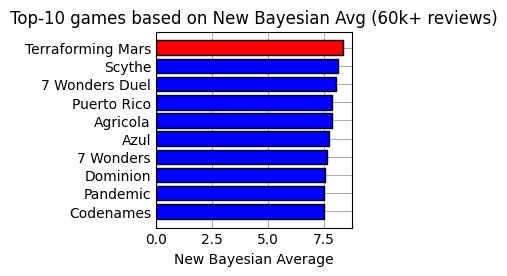

In [35]:
graph_setup = gr.graph('name_df', name_df2, 'New Bayesian Average', 'n')
graph_of_alg = graph_setup.horizontal_bar_graph('Top-10 games based on New Bayesian Avg (60k+ reviews)')

Against the standard arithmetic mean for the same amount of reviews:

In [41]:
name_df1 = rb.dataset_by_review_bracket('name_df', clean_rank_data, clean_review_data, None , 'greater', 60000)
name_df2 =  name_df1.add_column_to_df_filtered_by_reviews('Average', 'n')
name_df2 = name_df2.sort_values('Average', ascending = False)
name_df2

,ID,Name,Rank,Average,Number of Ratings
7,167791,Terraforming Mars,4,8.42,74216
12,169786,Scythe,14,8.22,64569
8,173346,7 Wonders Duel,16,8.11,69472
10,3076,Puerto Rico,31,7.97,65443
9,31260,Agricola,36,7.93,66093
15,230802,Azul,58,7.80,62802
3,68448,7 Wonders,73,7.74,89982
4,36218,Dominion,104,7.61,81561
6,178900,Codenames,101,7.60,74419
0,30549,Pandemic,106,7.59,108975


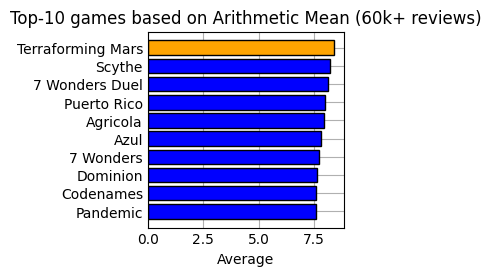

In [ ]:
graph_setup = gr.graph('name_df', name_df2, 'Average', 'n')
graph_of_alg = graph_setup.horizontal_bar_graph('Top-10 games based on Arithmetic Mean (60k+ reviews)', 'orange')

#### Results

Regarding the differences between a ranking based on the arithmetic mean and the algorithms that the project produces there are a few. 

As shown in the two graphs above, at the high levels some games are ranked in a slightly different way than others but overall there is not a huge difference as the number of games with a lot of reviews are few.

When the reviews become lower that is when more differences start arising, as a function such as the Bayesian Average puts much more emphasis on how many positive reviews a game's had compared to the average, so the lists are completely different and the algorithms are much more reliable:

In [68]:
name_df1 = rb.dataset_by_review_bracket('name_df', clean_rank_data, clean_review_data, ra.bayesian_average, 'between', 1000)    
name_df2 = name_df1.add_column_to_df_filtered_by_reviews('New Bayesian Average', 1100)
name_df2 = name_df2.sort_values('New Bayesian Average', ascending = False)
name_df2

,New Bayesian Average,ID,Name,Rank,Average,Number of Ratings
2735,7.93,3086,The Omega Virus,3829,6.41,1076
2758,7.88,165662,Haru Ichiban,2919,6.65,1061
2814,7.86,16497,Rat Hot,3895,6.30,1034
2842,7.85,283387,Rocketmen,2354,6.98,1020
2851,7.83,1044,Gunslinger,2191,7.13,1016
...,...,...,...,...,...,...
2850,4.73,131111,Codex: Card-Time Strategy – Deluxe Set,1357,8.05,1017
2868,4.46,1431,War at Sea (Second Edition),3363,6.52,1007
2852,4.24,42743,Opera,3117,6.61,1015
2754,4.18,42244,Martinique,3993,6.25,1065


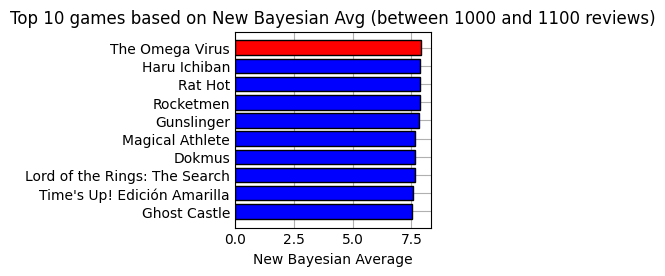

In [73]:
graph_setup = gr.graph('name_df', name_df2, 'New Bayesian Average', 'n')
new_graph = graph_setup.horizontal_bar_graph('Top 10 games based on New Bayesian Avg (between 1000 and 1100 reviews)')

In [44]:
name_df1 = rb.dataset_by_review_bracket('name_df', clean_rank_data, clean_review_data, ra.bayesian_average, 'between', 1000)    
name_df2 = name_df1.add_column_to_df_filtered_by_reviews('Average', 1100)
name_df2 = name_df2.sort_values('Average', ascending = False)
name_df2

,ID,Name,Rank,Average,Number of Ratings
2732,230791,Time of Legends: Joan of Arc,1747,8.13,1076
2760,281466,Yedo: Deluxe Master Set,1111,8.10,1060
2850,131111,Codex: Card-Time Strategy – Deluxe Set,1357,8.05,1017
2859,318182,Imperium: Legends,1216,8.04,1010
2813,20542,Advanced Squad Leader: Starter Kit #3,1264,8.04,1034
...,...,...,...,...,...
2846,113819,Tenzi,21753,4.90,1018
2857,13713,Solitaire,21789,4.40,1014
2753,5749,Simon,21793,4.33,1065
2867,7262,Top Trumps,21798,4.23,1007


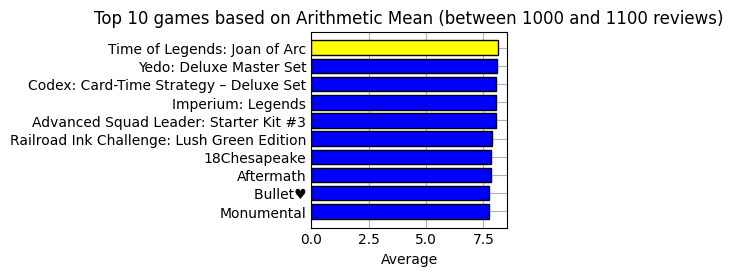

In [54]:
graph_setup = gr.graph('name_df', name_df2, 'Average', 'n')
graph_of_alg = graph_setup.horizontal_bar_graph('Top 10 games based on Arithmetic Mean (between 1000 and 1100 reviews)', 'yellow')

#### The project's main.py will look like:

In [ ]:
import Source.modules.dataset_by_review_bracket as rb
import Source.modules.ranking_algorithms as ra
import Source.modules.graph as gr
from Source.modules.data_processing import clean_rank_data, clean_review_data

In [93]:
def ranking_algorithm_by_reviews(ranking_algorithm, name_df, operator, num_of_reviews1, title_graph):
    '''Filters datasets by number of reviews and adds a new column to them with a specified new value, sorting by that value or not that value'''
    
    if ranking_algorithm == 'Wilson Score'.lower():
        name_df1 = rb.dataset_by_review_bracket(name_df, clean_rank_data, clean_review_data, ra.wilson_function, operator, num_of_reviews1)    
        name_df2 = name_df1.add_column_to_df_filtered_by_reviews('Wilson function')
        name_df2 = name_df2.sort_values('Wilson function', ascending = False)
        graph_setup = gr.graph(name_df, name_df2, 'Wilson function', 'n')
        graph_of_alg = graph_setup.horizontal_bar_graph(title_graph)
        
    elif ranking_algorithm =='Bayesian'.lower():
        name_df1 = rb.dataset_by_review_bracket(name_df, clean_rank_data, clean_review_data, ra.bayesian_average, operator, num_of_reviews1)    
        name_df2 = name_df1.add_column_to_df_filtered_by_reviews('New Bayesian Average')
        name_df2 = name_df2.sort_values('New Bayesian Average', ascending = False)
        graph_setup = gr.graph(name_df, name_df2, 'New Bayesian Average', 'n')
        graph_of_alg = graph_setup.horizontal_bar_graph(title_graph)
        
    elif ranking_algorithm == 'Average'.lower():
        name_df1 = rb.dataset_by_review_bracket(name_df, clean_rank_data, clean_review_data, None , operator, num_of_reviews1)
        name_df2 =  name_df1.add_column_to_df_filtered_by_reviews('Average', 'n')
        name_df2 = name_df2.sort_values('Average', ascending = False)
        graph_setup = gr.graph(name_df, name_df2, 'Average', 'n')
        graph_of_alg = graph_setup.horizontal_bar_graph(title_graph, 'orange')
        
    else:
        raise ValueError('Please enter a valid ranking algorithm name among "Wilson Function", "New Bayesian Average", and "Average"')
        
        
    return  graph_of_alg, name_df2

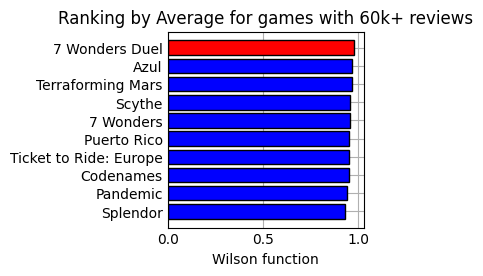

(None,
     Wilson function      ID                    Name  Rank  Average  \
 8              0.98  173346          7 Wonders Duel    16     8.11   
 15             0.97  230802                    Azul    58     7.80   
 7              0.97  167791       Terraforming Mars     4     8.42   
 12             0.96  169786                  Scythe    14     8.22   
 3              0.96   68448               7 Wonders    73     7.74   
 10             0.95    3076             Puerto Rico    31     7.97   
 14             0.95   14996  Ticket to Ride: Europe   131     7.54   
 6              0.95  178900               Codenames   101     7.60   
 0              0.94   30549                Pandemic   106     7.59   
 11             0.93  148228                Splendor   183     7.44   
 5              0.93    9209          Ticket to Ride   192     7.41   
 4              0.93   36218                Dominion   104     7.61   
 1              0.93     822             Carcassonne   190     7.42   

In [95]:
ranking_algorithm_by_reviews('wilson score', 'superman', 'greater', 60000, 'Ranking by Average for games with 60k+ reviews')